In [1]:
from typing import Optional
import scipy.io.wavfile as wav
import numpy as np
import matplotlib.pyplot as plt

海明窗：
$$
h\left(n\right)=\left\{\begin{array}{ll}
0.54 - 0.4\cos\left[2\pi n / \left(N - 1\right)\right], & 0 \leq n \leq N-1 \\
0, & \text { 其它 }
\end{array}\right. \\
$$

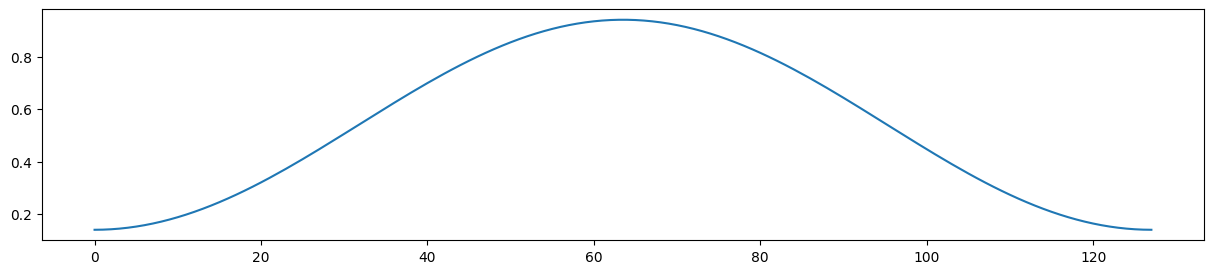

In [2]:
def hamming(frame_length:int) -> np.ndarray:
    # frame_length - 窗长

    n = np.arange(frame_length)
    h = 0.54 - 0.4 * np.cos(2 * np.pi * n / (frame_length - 1))
    
    return h

# 测试
h = hamming(128)
plt.figure(figsize=(15, 3))
plt.plot(h)
plt.show()

短时能量指在语音信号的不同时间段内，信号的能量或振幅的平均值。

短时能量的计算公式如下：
$$
    E_{n}=\sum_{m=-\infty}^{\infty}[x\left(m\right) h\left(n-m\right)]^{2}=\sum_{m=n-N+1}^{n}[x\left(m\right) h\left(n-m\right)]^{2}
$$
**计算短时能量的算法：将每一帧的语音信号提取出来，乘上窗长并平方，然后求和取平均，即可得出该帧的短时能量。将窗口移动步长个单位，重复前面的流程，直至分析完整段语音。**

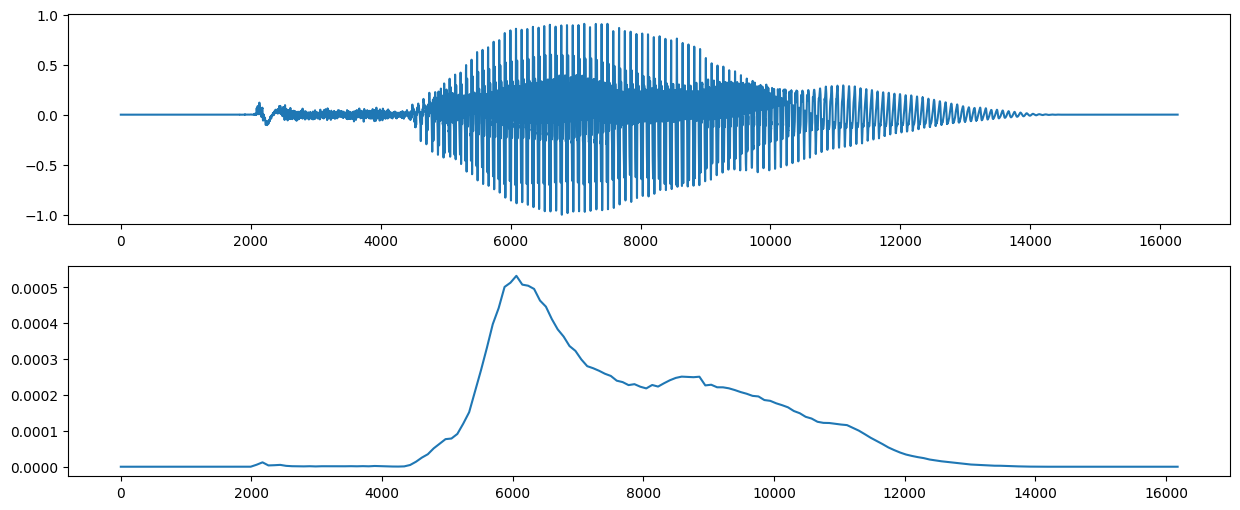

In [3]:
def ampf(x: np.ndarray, FrameLen: Optional[int] = 128, inc: Optional[int] = 90) -> np.ndarray:
    # x - 语音时域信号
    # FrameLen - 每一帧的长度
    # inc - 步长

    frames = []
    for i in range(0, len(x) - FrameLen, inc):
        frame = x[i : i + FrameLen]
        frames.append(frame)
    frames = np.array(frames)

    h = hamming(frame_length=FrameLen)[::-1] / FrameLen
    amp = np.dot(frames ** 2, h.T ** 2).T

    return amp


# 测试
sr, sound_array = wav.read("tang1.wav")
sound_array = sound_array.T[0, :] if sound_array.ndim != 1 else sound_array # 双通道改单通道
sound_array = sound_array / np.max(np.abs(sound_array))  # 归一化
FrameLen = 128
inc = 90
amp = ampf(sound_array, FrameLen, inc)
rescale_rate = len(sound_array) / amp.shape[0]
frameTime = np.arange(len(amp)) * rescale_rate
plt.figure(figsize=(15, 6))
plt.subplot(2, 1, 1)
plt.plot(sound_array)
plt.subplot(2, 1, 2)
plt.plot(frameTime, amp)
plt.show()

短时过零率指在语音信号的短时段内，信号穿过水平线（即振幅为0）的次数。定义如下：

窗函数：
$$
w\left(n\right)=\left\{\begin{array}{ll}
\frac{1}{2 N}, & 0 \leq n \leq N-1 \\
0, & \text { others }
\end{array}\right. \\
$$
短时过零率：
$$
Z_{n}=\sum_{m=-\infty}^{\infty}\left|\operatorname{sgn}\left[x\left(m\right)\right]-\operatorname{sgn}\left[x\left(m-1\right)\right]\right| w\left(n-m\right)
$$
其中$\operatorname{sgn}$是符号函数：
$$
\operatorname{sgn}\left(x\left(n\right)\right)=\left\{\begin{array}{ll}
1, & x\left(n\right) \geq 0 \\
-1, & x\left(n\right)<0
\end{array}\right.
$$
**计算短时过零率的算法：先从语音信号中计算出过零序列（经过$\operatorname{sgn}$转化后，后一信号减前一信号）。然后将每一帧的语音信号对应的过零序列提取出来，求和并除以帧长，即为该帧的过零率。将窗口移动步长个单位，重复前面的流程，直至分析完整段语音。**

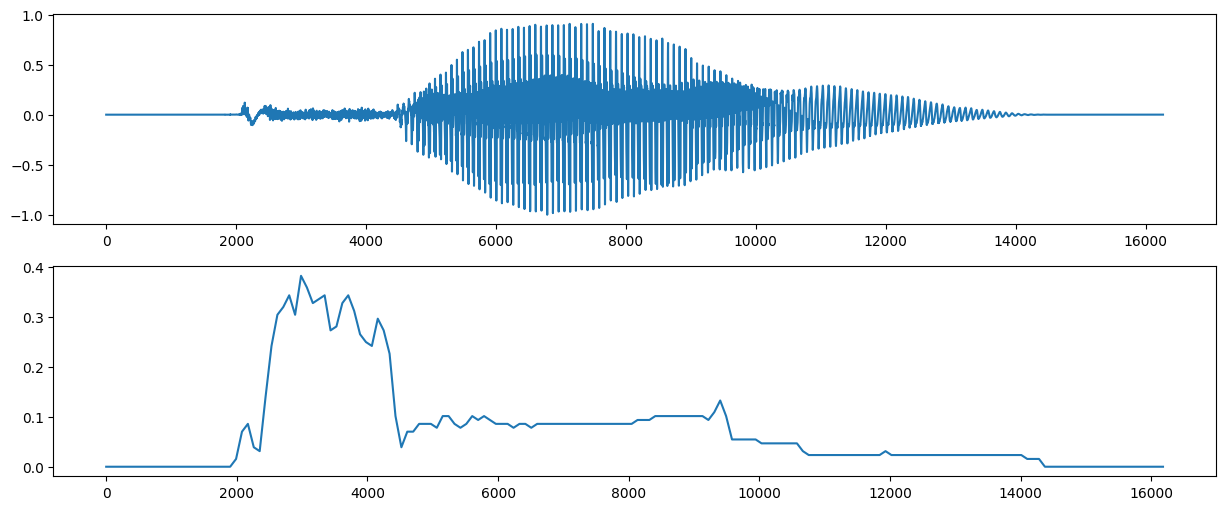

In [4]:
def zcrf(x: np.ndarray, FrameLen: Optional[int] = 128, inc: Optional[int] = 90) -> np.ndarray:
    # x - 语音时域信号
    # FrameLen - 每一帧的长度
    # inc - 步长

    sound = x
    sgn_sound = np.sign(sound)
    dif_sound = np.abs(sgn_sound[1:] - sgn_sound[:-1])
    frames = []
    for i in range(0, len(dif_sound) - FrameLen, inc):
        frame = dif_sound[i : i + FrameLen]
        frames.append(frame)
    frames = np.array(frames)
    
    h = np.ones((FrameLen,)) / (2 * FrameLen)
    zcr = np.dot(frames, h.T).T
    
    return zcr


# 测试
sr, sound_array = wav.read("tang1.wav")
sound_array = sound_array.T[0, :] if sound_array.ndim != 1 else sound_array # 双通道改单通道
sound_array = sound_array / np.max(np.abs(sound_array))  # 归一化
FrameLen = 128
inc = 90
zcr = zcrf(sound_array, FrameLen, inc)
rescale_rate = len(sound_array) / amp.shape[0]
frameTime = np.arange(len(amp)) * rescale_rate
plt.figure(figsize=(15, 6))
plt.subplot(2, 1, 1)
plt.plot(sound_array)
plt.subplot(2, 1, 2)
plt.plot(frameTime, zcr)
plt.show()

将每个发音分为3个阶段：

1. 未发声阶段：此时短时能量和短时过零率都很低
2. 声母阶段：此时声母的塞音、擦音和塞擦音等会产生大量的高频声波，过零率较大；但是此时韵母还没发出，短时能量较低。这一阶段的开始为`x1`。
3. 韵母阶段：此时韵母发出，频率趋于平稳和下降，因此此时过零率下降，但短时能量激增，并逐渐减少，直至发声完毕，回到1阶段。这一阶段的开始为`x3`，结束为`x2`。

**一开始将阶段初始化为`1`未发声阶段；接着当过零率高于阈值时，进入`2`声母阶段，添加`x1`；接着当短时能量高于阈值时，进入`3`声母阶段，添加`x3`；在进入`2`或`3`阶段后，当短时能量和短时过零率同时低于阈值时，重置为`1`未发声阶段，添加`x2`。**

**另外还设置了一个阈值宽度，当语音信号在大于阈值宽度的信号段满足条件才算通过。**

In [5]:
def analyze_sound(filename: str, FrameLen: Optional[int] = 128, inc: Optional[int] = 90) -> None:
    sr, sound_array = wav.read(filename)
    sound_array = sound_array.T[0, :] if sound_array.ndim != 1 else sound_array # 双通道改单通道
    sound_array = sound_array / np.max(np.abs(sound_array))  # 归一化
    
    amp = ampf(sound_array, FrameLen, inc)
    zcr = zcrf(sound_array, FrameLen, inc)
    
    rescale_rate = len(sound_array) / amp.shape[0]
    frameTime = np.arange(len(amp)) * rescale_rate
    # 将曲线图拉伸至和语音信号图一样长，方便分析
    
    x1 = []
    x2 = []
    x3 = []
    amp2 = np.min(amp) + (np.max(amp) - np.min(amp)) * 0.05
    zcr2 = np.min(zcr) + (np.max(zcr) - np.min(zcr)) * 0.04
    
    threshold_len = 6
    state = 1
    for i in range(threshold_len, len(amp) - threshold_len):
        if state == 1:
            if np.all(zcr[i : i + threshold_len] > zcr2):
                x1.append(i * rescale_rate)
                state = 2
        elif state == 2:
            if np.all(amp[i : i + threshold_len] > amp2):
                x3.append(i * rescale_rate)
                state = 3
        if state != 1 and np.all(amp[i : i + threshold_len] < amp2) and np.all(zcr[i : i + threshold_len] < zcr2):
            x2.append(i * rescale_rate)
            state = 1
    
    # 绘制语音波形、短时能量、短时过零率
    plt.figure(figsize=(12, 8))

    # 语音波形
    plt.subplot(3, 1, 1)
    plt.plot(sound_array)
    plt.title("Waveform")
    for boundary in x1:
        plt.axvline(x=boundary, color="r", linestyle="--", linewidth=0.8)
    for boundary in x2:
        plt.axvline(x=boundary, color="b", linestyle="--", linewidth=0.8)
    for boundary in x3:
        plt.axvline(x=boundary, color="g", linestyle="--", linewidth=0.8)
    
    # 短时能量
    plt.subplot(3, 1, 2)
    plt.plot(frameTime, amp, label="Energy")
    plt.axhline(y=amp2, color="r", linestyle="--", label="Energy Threshold", linewidth=0.8)
    plt.legend()
    plt.title("Short-time Energy")
    for boundary in x1:
        plt.axvline(x=boundary, color="r", linestyle="--", linewidth=0.8)
    for boundary in x2:
        plt.axvline(x=boundary, color="b", linestyle="--", linewidth=0.8)
    for boundary in x3:
        plt.axvline(x=boundary, color="g", linestyle="--", linewidth=0.8)
    
    # 短时过零率
    plt.subplot(3, 1, 3)
    plt.plot(frameTime, zcr, label="Zero Crossing Rate")
    plt.axhline(y=zcr2, color="r", linestyle="--", label="ZCR Threshold", linewidth=0.8)
    plt.legend()
    plt.title("Short-time Zero Crossing Rate")
    for boundary in x1:
        plt.axvline(x=boundary, color="r", linestyle="--", linewidth=0.8)
    for boundary in x2:
        plt.axvline(x=boundary, color="b", linestyle="--", linewidth=0.8)
    for boundary in x3:
        plt.axvline(x=boundary, color="g", linestyle="--", linewidth=0.8)
    
    plt.tight_layout()
    plt.show()

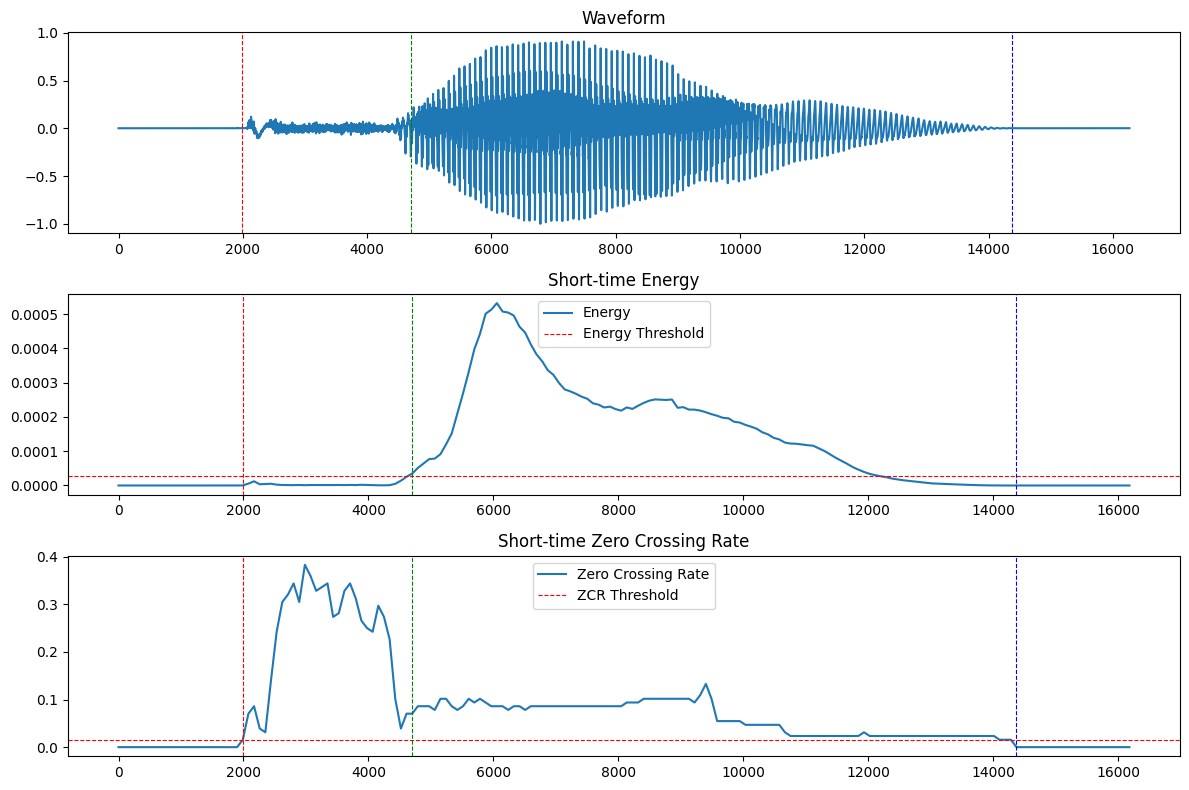

In [6]:
analyze_sound("tang1.wav", FrameLen=128, inc=90)

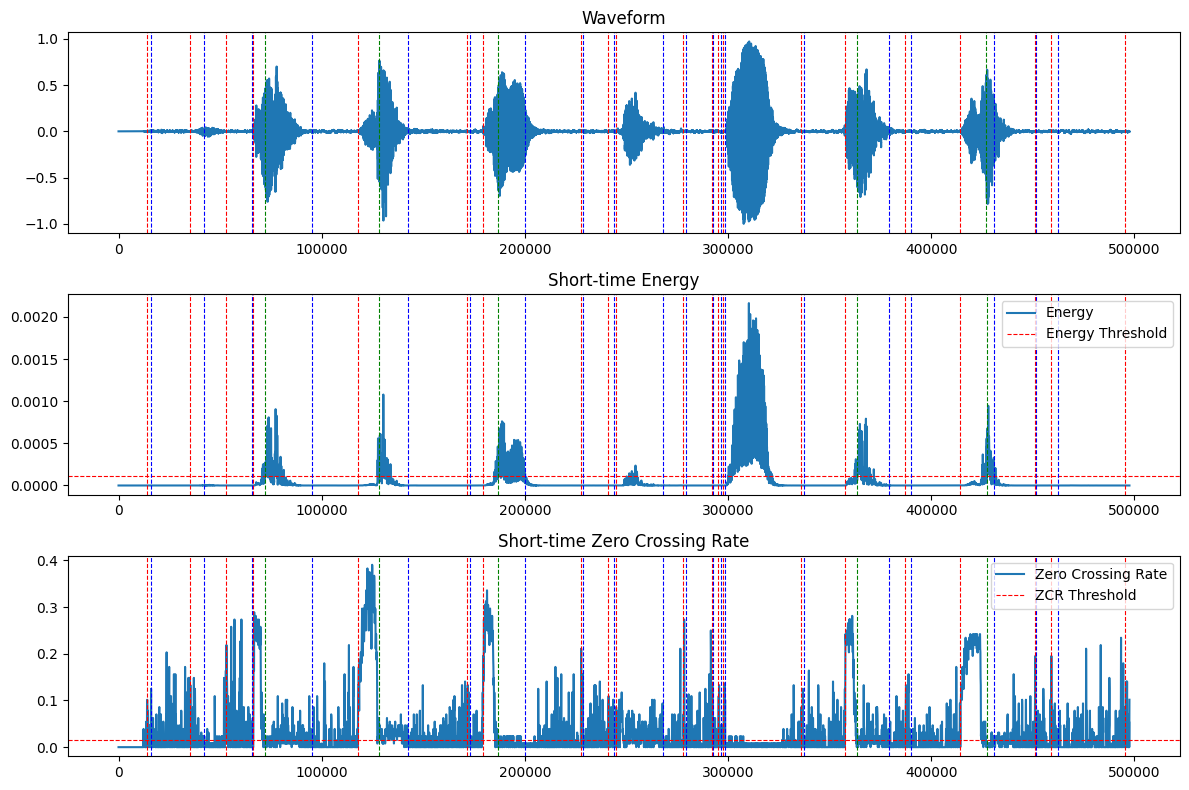

In [7]:
analyze_sound("voice.wav", FrameLen=128, inc=90)

噪声背景下的修正$\operatorname{sgn}$函数：
$$
\operatorname{sgn}\left(x\left(n\right)\right)=\left\{\begin{array}{ll}
1, & x\left(n\right) \geq \Delta \\
-1, & x\left(n\right)< -\Delta\\
0, & \text{others}
\end{array}\right.
$$
具体的实现中，我使用矩阵运算语音信号，逐采样点判断$x\left(n\right)$和$\pm \Delta$的大小既不经济，不优雅。因此，我首先将$x\left(n\right)$进行了变换，即将修正$\operatorname{sgn}$函数改写为：
$$
\operatorname{sgn}\left(x\left(n\right)\right)=\left\{\begin{array}{ll}
1, & x\left(n\right) \geq 0 \wedge  x\left(n\right) - \Delta \geq 0\\
-1, & x\left(n\right) < 0 \wedge  x\left(n\right) + \Delta< 0\\
0, & \text{others}
\end{array}\right.
$$
相当于正负值信号都向横坐标轴缩减了$\Delta$，再进行普通的$\operatorname{sgn}$操作。

所以，首先将语音信号减去阈值$\Delta$，去掉负值信号，得到正值信号；将语音信号加上阈值$\Delta$，去掉正值信号，得到负值信号。再将两者相加合并，得到处理后的语音信号。最后，进行普通的普通的$\operatorname{sgn}$函数操作。数操作。torname{sgn}$函数操作。

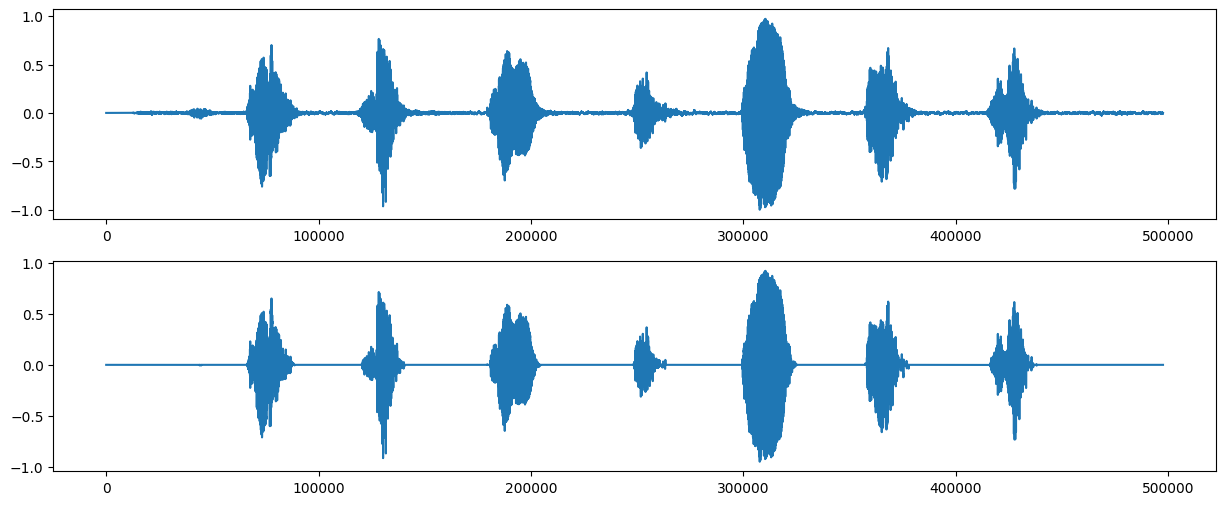

In [8]:
sr, sound_array = wav.read("voice.wav")
sound_array = sound_array.T[0, :] if sound_array.ndim != 1 else sound_array
sound_array = sound_array / np.max(np.abs(sound_array))  # 归一化

sound = sound_array
threshold = np.max(np.abs(sound)) / 20
negative_sound = sound + threshold
negative_sound -= np.abs(negative_sound)
positive_sound = sound - threshold
positive_sound += np.abs(positive_sound)
sound = (negative_sound + positive_sound) / 2

plt.figure(figsize=(15, 6))
plt.subplot(2, 1, 1)
plt.plot(sound_array)
plt.subplot(2, 1, 2)
plt.plot(sound)
plt.show()

In [9]:
def delta_sgn(x: np.ndarray) -> np.ndarray:
    # x - 语音信号
    
    sound = x
    threshold = np.max(np.abs(sound)) / 20
    negative_sound = sound + threshold
    negative_sound -= np.abs(negative_sound)
    positive_sound = sound - threshold
    positive_sound += np.abs(positive_sound)
    sound = (negative_sound + positive_sound) / 2
    
    return np.sign(sound)

采用噪声背景下的修正$\operatorname{sgn}$函数的短时过零率计算函数。

In [10]:
def zcrf_delta(x: np.ndarray, FrameLen: Optional[int] = 128, inc: Optional[int] = 90) -> np.ndarray:
    # x - 语音时域信号
    # FrameLen - 每一帧的长度
    # inc - 步长

    sound = x
    sgn_sound = delta_sgn(sound)

    dif_sound = np.abs(sgn_sound[1:] - sgn_sound[:-1])
    h = np.ones((FrameLen,)) / (2 * FrameLen)

    frames = []
    for i in range(0, len(dif_sound) - FrameLen, inc):
        frame = dif_sound[i : i + FrameLen]
        frames.append(frame)

    frames = np.array(frames)
    zcr = np.dot(frames, h.T).T
    return zcr

In [11]:
def analyze_sound(filename: str, FrameLen: Optional[int] = 128, inc: Optional[int] = 90) -> None:
    sr, sound_array = wav.read(filename)
    sound_array = sound_array.T[0, :] if sound_array.ndim != 1 else sound_array # 双通道改单通道
    sound_array = sound_array / np.max(np.abs(sound_array))  # 归一化
    
    amp = ampf(sound_array, FrameLen, inc)
    zcr = zcrf_delta(sound_array, FrameLen, inc)
    
    rescale_rate = len(sound_array) / amp.shape[0]
    frameTime = np.arange(len(amp)) * rescale_rate
    # 将曲线图拉伸至和语音信号图一样长，方便分析
    
    x1 = []
    x2 = []
    x3 = []
    amp2 = np.min(amp) + (np.max(amp) - np.min(amp)) * 0.05
    zcr2 = np.min(zcr) + (np.max(zcr) - np.min(zcr)) * 0.04
    
    threshold_len = 6
    state = 1
    for i in range(threshold_len, len(amp) - threshold_len):
        if state == 1:
            if np.all(zcr[i : i + threshold_len] > zcr2):
                x1.append(i * rescale_rate)
                state = 2
        elif state == 2:
            if np.all(amp[i : i + threshold_len] > amp2):
                x3.append(i * rescale_rate)
                state = 3
        if state != 1 and np.all(amp[i : i + threshold_len] < amp2) and np.all(zcr[i : i + threshold_len] < zcr2):
            x2.append(i * rescale_rate)
            state = 1
    
    # 绘制语音波形、短时能量、短时过零率
    plt.figure(figsize=(12, 8))

    # 语音波形
    plt.subplot(3, 1, 1)
    plt.plot(sound_array)
    plt.title("Waveform")
    for boundary in x1:
        plt.axvline(x=boundary, color="r", linestyle="--", linewidth=0.8)
    for boundary in x2:
        plt.axvline(x=boundary, color="b", linestyle="--", linewidth=0.8)
    for boundary in x3:
        plt.axvline(x=boundary, color="g", linestyle="--", linewidth=0.8)
    
    # 短时能量
    plt.subplot(3, 1, 2)
    plt.plot(frameTime, amp, label="Energy")
    plt.axhline(y=amp2, color="r", linestyle="--", label="Energy Threshold", linewidth=0.8)
    plt.legend()
    plt.title("Short-time Energy")
    for boundary in x1:
        plt.axvline(x=boundary, color="r", linestyle="--", linewidth=0.8)
    for boundary in x2:
        plt.axvline(x=boundary, color="b", linestyle="--", linewidth=0.8)
    for boundary in x3:
        plt.axvline(x=boundary, color="g", linestyle="--", linewidth=0.8)
    
    # 短时过零率
    plt.subplot(3, 1, 3)
    plt.plot(frameTime, zcr, label="Zero Crossing Rate")
    plt.axhline(y=zcr2, color="r", linestyle="--", label="ZCR Threshold", linewidth=0.8)
    plt.legend()
    plt.title("Short-time Zero Crossing Rate")
    for boundary in x1:
        plt.axvline(x=boundary, color="r", linestyle="--", linewidth=0.8)
    for boundary in x2:
        plt.axvline(x=boundary, color="b", linestyle="--", linewidth=0.8)
    for boundary in x3:
        plt.axvline(x=boundary, color="g", linestyle="--", linewidth=0.8)
    
    plt.tight_layout()
    plt.show()

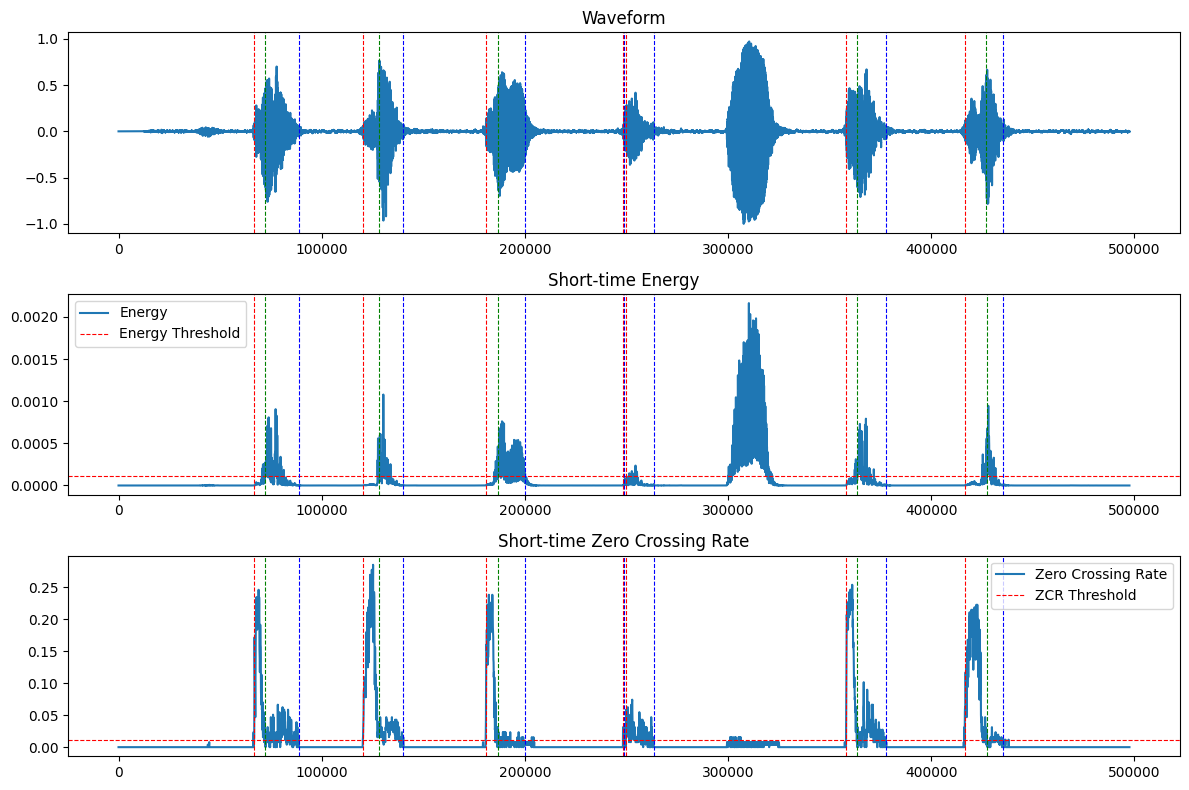

In [12]:
analyze_sound("voice.wav", FrameLen=128, inc=90)

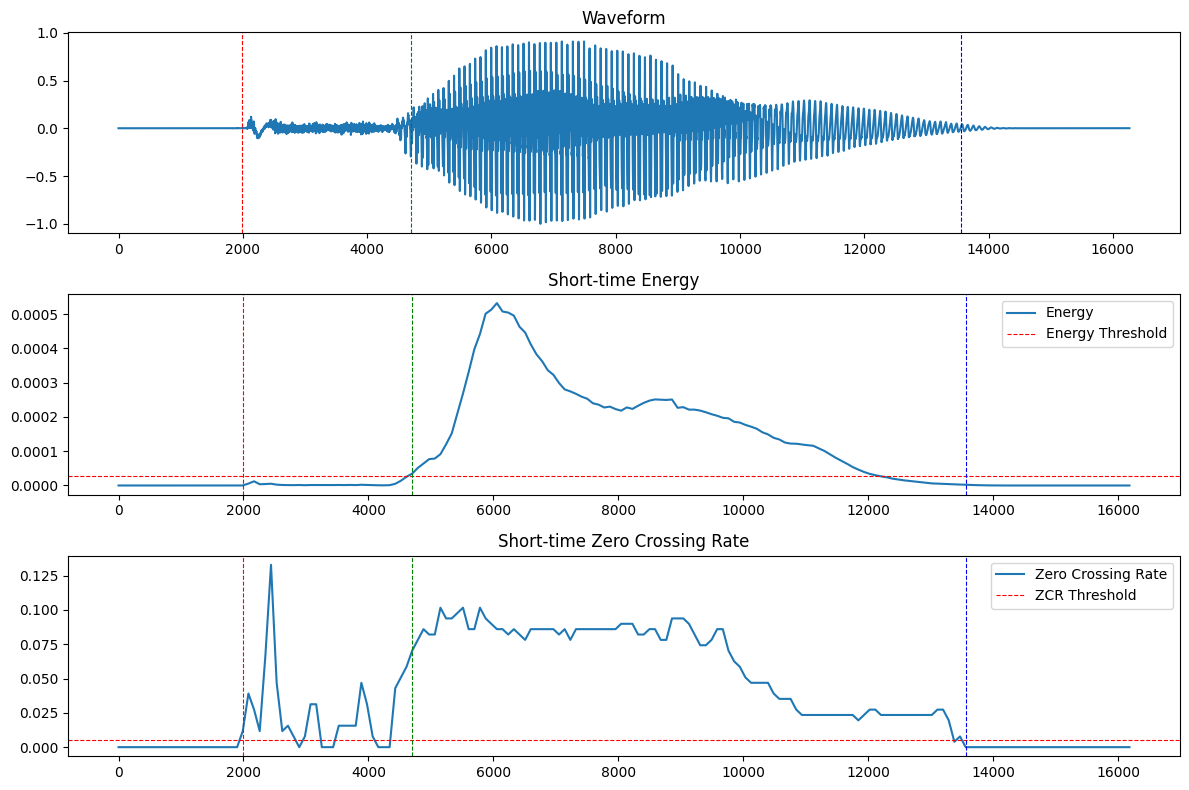

In [13]:
analyze_sound("tang1.wav", FrameLen=128, inc=90)